In [1]:
%pip install torch


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\Simons Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\Simons Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Simons Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Simons Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Simons Lenovo\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 466, in


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/74/07/edce54779f5c3fe8ab8390eafad3d7c8190fce68f922a254ea77f4a94a99/torch-2.1.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     --------------------

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

ModuleNotFoundError: No module named 'torch'

bias is set to False, since it would be cancelled out by the batchnorm anyway. Batchnorm

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
            ):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Good idea to have an input divisible by 2^4 (4 layers in depth) to avoid problems with inputs not having the same height and width

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    # feature*2 gets saved to feature
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # features[-1] gets 512 that is the last of our features from the UNET
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,)

    def forward(self, x):
        skip_connections = []

        # Order is important: first with highest resolution and last with lowest
        for downs in self.downs:
            x = downs(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        # Reversing skip_connections
        skip_connections = skip_connections[::-1]

        # Reason for step = 2, is because we want to double conv for each step up
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            # idx//2 to compensate for step = 2
            skip_connection = skip_connections[idx//2]

            # Resizes if shape is not the same
            if x.shape != skip_connection.shape:
                # Takes out only the height and the width, so skipping batch-size and number of channels
                x = FT.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
    def test():
        # Batch size of 3, input 1 channel, 160 for features, which is perfectly divisible
        x = torch.random((3, 1, 160, 160))
        model = UNET(in_channels=1, out_channels=1)
        preds = model(x)
        # Make sure that input is the exact same shape as output
        print(preds.shape)
        print(x.shape)

In [1]:
%pip install opencv-contrib-python
%pip install roboflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/4f/2c/13ef4a1811365208f7441dae564ea57dad4b58762196b7d8e65860b0cc07/roboflow-1.1.7-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/155.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/155.3 kB ? eta -:--:--
     -- ------------------------------------- 10.2/155.3 kB ? eta -:--:--
     ------- ----------------------------- 30.7/155.3 kB 330.3 kB/s eta 0:00:01
     ------- ----------------------------- 30.7/155.3 kB 330.3 kB/s eta 0:00:01
     -------------- ---------------------- 61.4/155.3 kB 328.2 kB/s eta 0:00:01
     -------------------------- --------- 112.6/155.3 kB 467.6 kB/s eta 0:00:01
     ------------------------------------ 155.3/155.3 kB 580.1 kB/s eta 0:00:00
     ---------------------------------------- 0.0/178.7 kB ? eta -:--:--
     ------ ------------------------------ 30.7/178.7 kB 660.6 kB/s eta 0:00:01
     -------------- -----

In [11]:
from roboflow import Roboflow
import cv2
import numpy as np
import requests
import json
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [12]:
rf = Roboflow(api_key="e6vqYw2hVrLBzvqxJoQc")
project = rf.workspace().project("taco-trash-annotations-in-context")
model = project.version(16).model

loading Roboflow workspace...
loading Roboflow project...


In [21]:
# infer on a local image
print(model.predict('best_pic_0.png').json())

{'predictions': [{'x': 146.0, 'y': 331.0, 'width': 48.0, 'height': 62.0, 'confidence': 0.9340426325798035, 'class': 'trash', 'points': [{'x': 140.546875, 'y': 300.346875}, {'x': 140.546875, 'y': 300.9125}, {'x': 140.0, 'y': 301.47812500000003}, {'x': 140.0, 'y': 302.609375}, {'x': 134.53125, 'y': 308.265625}, {'x': 133.984375, 'y': 308.265625}, {'x': 131.796875, 'y': 310.52812500000005}, {'x': 131.25, 'y': 310.52812500000005}, {'x': 131.25, 'y': 311.09375}, {'x': 128.515625, 'y': 313.921875}, {'x': 127.96875, 'y': 313.921875}, {'x': 126.875, 'y': 315.053125}, {'x': 126.328125, 'y': 315.053125}, {'x': 124.140625, 'y': 317.315625}, {'x': 124.140625, 'y': 317.88125}, {'x': 123.59375, 'y': 318.44687500000003}, {'x': 123.046875, 'y': 318.44687500000003}, {'x': 123.046875, 'y': 319.01250000000005}, {'x': 122.5, 'y': 319.578125}, {'x': 122.5, 'y': 334.284375}, {'x': 124.140625, 'y': 335.98125000000005}, {'x': 124.140625, 'y': 336.546875}, {'x': 125.78125, 'y': 338.24375000000003}, {'x': 125.7

In [22]:
model.predict("best_pic_0.png").save("seg_prediction.png")

#### Cropping img

In [23]:
image = cv2.imread('best_pic_0.png')

In [24]:
predictions_data = model.predict('best_pic_0.png').json()

In [25]:
for index, prediction in enumerate(predictions_data['predictions']):
    x, y, width, height = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])
    
    # Crop the area based on bounding box coordinates
    roi_x = int(prediction['x'] - prediction['width'] / 2)
    roi_y = int(prediction['y'] - prediction['height'] / 2)
    roi_width = int(prediction['width'])
    roi_height = int(prediction['height'])

    cropped_area = image[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
    
    # Save the cropped area
    cv2.imwrite(f'cropped_object_{index}.png', cropped_area)
    
    # Draw circle on the cropped area, adjust the x, y relative to the cropped area
    relative_x = x - roi_x
    relative_y = y - roi_y
    cv2.circle(cropped_area, (relative_x, relative_y), 5, (0, 0, 255), -1)  # Radius=5, Color=Green, Thickness=-1 (filled)
    
    # Draw coordinates above the circle
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"({relative_x}, {relative_y})"
    text_size = cv2.getTextSize(text, font, 0.5, 1)[0]
    text_x = relative_x - text_size[0] // 2
    text_y = relative_y - 10  # 10 pixels above the circle
    cv2.putText(cropped_area, text, (text_x, text_y), font, 0.5, (0, 0, 255), 1)

    
    # Save the cropped area with the circle
    cv2.imwrite(f'cropped_object_with_circle_{index}.png', cropped_area)

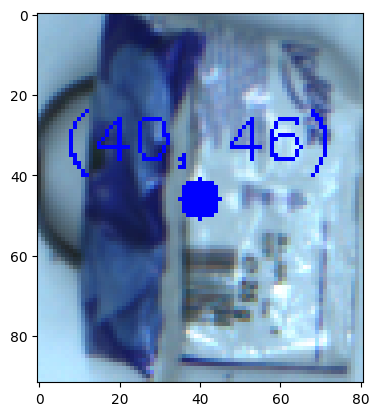

In [31]:

image = cv2.imread('cropped_object_with_circle_1.png')
plt.imshow(image)

{"id":"aa5a7aaa-1cd5-4a5f-ab63-13a8081e1b10","project":"0099a351-a017-4271-8ae9-fac952b93363","iteration":"30dd718a-4bc5-4e24-9d81-95484c7bc8bf","created":"2023-10-25T20:51:54.297Z","predictions":[{"probability":0.99349666,"tagId":"ae0c1bb6-fbfc-4c77-a7d7-d2283811a98b","tagName":"Foil","boundingBox":{"left":0.34431243,"top":0.80525535,"width":0.14862567,"height":0.19251382}},{"probability":0.6260224,"tagId":"ae0c1bb6-fbfc-4c77-a7d7-d2283811a98b","tagName":"Foil","boundingBox":{"left":0.27679446,"top":0.9467383,"width":0.10462105,"height":0.053261697}},{"probability":0.3944887,"tagId":"ae0c1bb6-fbfc-4c77-a7d7-d2283811a98b","tagName":"Foil","boundingBox":{"left":0.33721113,"top":0.50869536,"width":0.10554719,"height":0.24733073}},{"probability":0.20772278,"tagId":"ae0c1bb6-fbfc-4c77-a7d7-d2283811a98b","tagName":"Foil","boundingBox":{"left":0.28102547,"top":0.9335312,"width":0.09190005,"height":0.066468775}},{"probability":0.14690043,"tagId":"ae0c1bb6-fbfc-4c77-a7d7-d2283811a98b","tagName

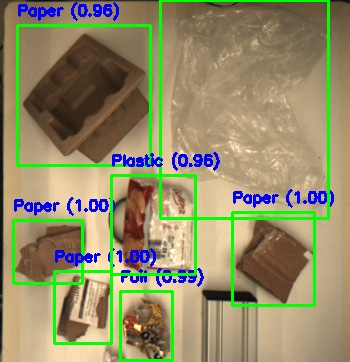

In [33]:
import cv2
import numpy as np
import requests
import json
from IPython.display import Image, display

 
url = 'https://sickcv-prediction.cognitiveservices.azure.com/customvision/v3.0/Prediction/0099a351-a017-4271-8ae9-fac952b93363/detect/iterations/trashRecognizer/image'

# Load the original image
original_image = cv2.imread('best_pic_0.png') 

 # ('',('best_pic_0.png',open('/Volumes/Untitled/rgb_0.png','rb'),'image/png'))
payload = {}
files=[
  #  ('',('best_pic_0',open('C:\\Users\\Simons Lenovo\\Desktop\\Hackathon_2023\\Test_data\\best_pic_0','rb'),'image\\png'))
  ('',('best_pic_0.png',open('best_pic_0.png','rb'),'image/png'))
]
headers = {
  'Prediction-Key': '3fc4ab02162c46379ebce6444363943f'
}
 
response = requests.request("POST", url, headers=headers, data=payload, files=files)
print(response.text)

# Assuming 'response' contains the JSON response
response_json = json.loads(response.text)

# Set the confidence threshold (adjust as needed)
confidence_threshold = 0.8

# Iterate through detected objects in the response
for prediction in response_json['predictions']:
    label = prediction['tagName']
    confidence = prediction['probability']

    # Check if the confidence score exceeds the threshold
    if confidence >= confidence_threshold:
        # Get bounding box coordinates
        left = int(prediction['boundingBox']['left'] * original_image.shape[1])
        top = int(prediction['boundingBox']['top'] * original_image.shape[0])
        width = int(prediction['boundingBox']['width'] * original_image.shape[1])
        height = int(prediction['boundingBox']['height'] * original_image.shape[0])

        # Draw bounding box
        cv2.rectangle(original_image, (left, top), (left + width, top + height), (0, 255, 0), 2)

        # Display label and confidence
        label_text = f"{label} ({confidence:.2f})"
        cv2.putText(original_image, label_text, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Save the image with bounding boxes and labels to a file
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, original_image)

# Display the saved image in the Jupyter Notebook
display(Image(filename=output_image_path))